<a href="https://colab.research.google.com/github/kyalan/DataScienceFactory/blob/master/20200419_imdb_reviews/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard
%matplotlib inline

import os, sys
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
from datetime import datetime as dt
import sklearn.metrics
import seaborn as sns

from matplotlib import pyplot as plt

In [15]:
try:
    %tensorflow_version 2.x
except:
    pass

print(tf.__version__)
print(tfds.__version__)

2.2.0-rc3
2.1.0


In [0]:
# Check GPU is avaliable
assert len(tf.config.list_physical_devices('GPU'))==1

# Import data

In [17]:
(ds_train, ds_dev, ds_test), info = tfds.load('imdb_reviews', split=('train[:80%]', 'train[80%:]', 'test')
    # , shuffle_files=True
    , with_info=True, as_supervised=True)
print(info)
n_train, n_dev, n_test = len(list(ds_train)), len(list(ds_dev)), len(list(ds_test))
print('no. of data for train, dev, test', n_train, n_dev, n_test)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},
      title     = {Learning Word

In [18]:
INPUT_SHAPE = info.features['text'].shape
LABEL_NAMES = info.features['label'].names
N_LABELS = info.features['label'].num_classes
print('INPUT_SHAPE shape:{}'.format(INPUT_SHAPE))
print('LABEL_NAMES:{}'.format(LABEL_NAMES))

INPUT_SHAPE shape:()
LABEL_NAMES:['neg', 'pos']


In [19]:
# check data structure
for txt, label in ds_train.take(1):
    print(txt.numpy().decode())
    print('LABEL: {} - {}'.format(label.numpy(), LABEL_NAMES[label]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
LABEL: 0 - neg


In [20]:
for i in range(N_LABELS):
    ds_temp_train = ds_train.filter(lambda img, label: label==i)
    for txt, label in ds_temp_train.take(1):
        print(txt.numpy().decode())
        print('LABEL: {} - {}'.format(label.numpy(), LABEL_NAMES[label]))

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
LABEL: 0 - neg
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful performances from Cher and Nicolas Cage (as always) gently row the plot along. 

# Pre-processing

In [0]:
# Embedded layer construction
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from itertools import chain

VOCAB_SIZE = 1000
EMBEDDING_DIM = 16
MAX_LENGTH = 120
TRUNC_TYPE='post'
PADDING_TYPE='post'
OOV_TOK = "<OOV>"

# Train the tokenizer
tokenizer = Tokenizer(num_words = VOCAB_SIZE, oov_token=OOV_TOK)
sentences = [txts.numpy().decode() for txts, _ in ds_train]
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index

In [0]:
def padder(sentences):
    # word embedder
    sequences = tokenizer.texts_to_sequences([x.decode() for x in sentences.numpy()])
    padded = pad_sequences(sequences, padding=PADDING_TYPE, maxlen=MAX_LENGTH)
    return padded

padded_train, label_train = next(iter(ds_train.batch(n_train).take(1)))
padded_train = padder(padded_train)
padded_dev, label_dev = next(iter(ds_train.batch(n_dev).take(1)))
padded_dev = padder(padded_dev)

print(padded_train.shape, label_train.shape, padded_dev.shape, label_dev.shape)

In [0]:
# ds_train = ds_train.cache().shuffle(n_train).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
# ds_dev = ds_dev.batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

# ds_train_padded = ds_train_padded.shuffle(n_train).batch(128)
# ds_dev_padded = ds_dev_padded.batch(128)

# Modeling

In [0]:
def getModel():
    from tensorflow.keras import Sequential, regularizers
    from tensorflow.keras.layers import InputLayer, Lambda, Embedding, Dense, Dropout, Bidirectional, LSTM
    from tensorflow.keras.optimizers import Adam

    regularizer = regularizers.l2(0.001)

    model = Sequential()
    # model.add(InputLayer())
    # model.add(Lambda(padder))
    model.add(Embedding(VOCAB_SIZE+1, EMBEDDING_DIM))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(2, activation='softmax'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['acc'])
    print(model.summary())
    return model

In [0]:
# Callbacks
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# cb_earlystop = EarlyStopping(patience=10)
# cb_learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
#                                             patience=2, 
#                                             verbose=1, 
#                                             factor=0.5, 
#                                             min_lr=0.00001)

# Tensorboards callback setting
# Clear logs prior to logging data.
# !rm -rf logs

# Create log directory
# logdir = "logs/" + dt.now().strftime("%Y%m%d-%H%M%S")
# cb_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [41]:
%%time

model = getModel()

# %tensorboard --logdir logs
history = model.fit(x=padded_train, y=label_train
                    , epochs=5, validation_data=(padded_dev, label_dev), verbose=1
                    # , callbacks=[cb_tensorboard]
                    # , callbacks=[cb_earlystop, cb_learning_rate_reduction]
                    )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          16016     
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                4224      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 20,802
Trainable params: 20,802
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
625/625 [==============================] - 10s 15ms/step - loss: 0.5259 - acc: 0.7239 - val_loss: 0.4329 - val_acc: 0.8072
Epoch 2/5
625/625 [==============================] - 9s 14ms/step - loss: 0.3770 - acc: 0.8366 - val_loss: 0.3

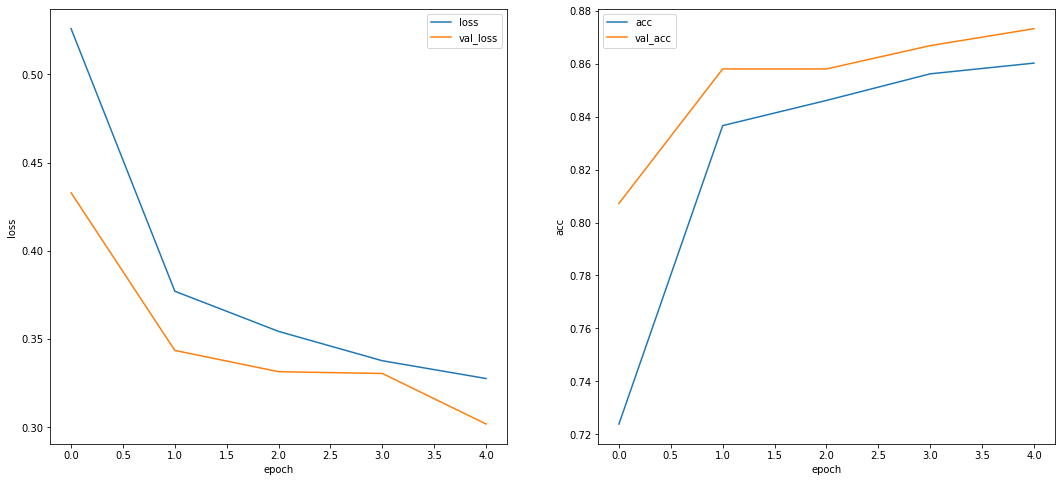

In [42]:
def plot_history(history):
    hist = history.history
    fig = plt.figure(figsize=(18, 8))
    iplot = 0
    for key in ['loss', 'acc']:
        iplot += 1
        fig.add_subplot(1, 2, iplot)
        plt.xlabel('epoch')
        plt.ylabel(key)
        plt.plot(range(len(hist[key])), hist[key], label = key)
        plt.plot(range(len(hist['val_' + key])), hist['val_' + key], label = 'val_' + key)
        plt.legend()
    plt.show()

plot_history(history)

# Model Evaluation

In [43]:
padded_test, label_test = next(iter(ds_test.batch(n_test).take(1)))
padded_test = padder(padded_test)

eval = model.evaluate(padded_test, label_test)
print('Test data: Loss = {}, Accuracy = {}'.format(eval[0], eval[1]))
print('Right Prediction: {}, Wrong Prediction: {}'.format(eval[1]*n_test, (1.0-eval[1])*n_test))

tf.Tensor(
[b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come."
 b"A blackly comic tale of a down-trodden pri

In [45]:
%%time

test_labels = np.array(label_test)
test_pred = model.predict(padded_test).argmax(axis=1)

CPU times: user 6.13 s, sys: 571 ms, total: 6.7 s
Wall time: 5.2 s


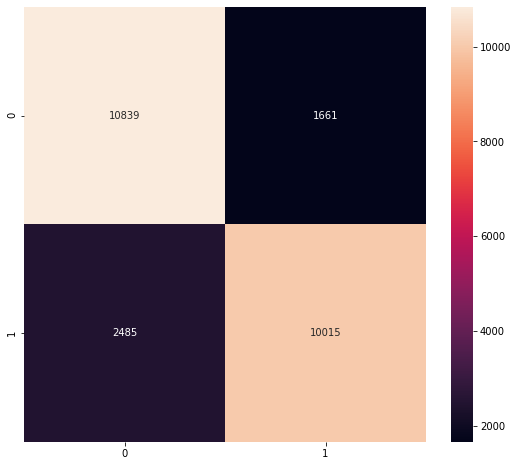

In [46]:
cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
fig = plt.figure(figsize=(9, 8))
sns.heatmap(pd.DataFrame(cm, range(N_LABELS), range(N_LABELS)), annot=True, fmt='d')

In [47]:
nrows, ncols = 2, 5

itxts = np.where(test_labels!=test_pred)[0]
for i in range(10):
    itxt = itxts[i]
    for txt, label in ds_test.skip(itxt).take(1):
        print(txt.numpy().decode())
        print('PREDICT: {} - {} ; LABEL: {} - {}'.format(test_pred[itxt], LABEL_NAMES[test_pred[itxt]], label.numpy(), LABEL_NAMES[label]))        

There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.
PREDICT: 0 - neg ; LABEL: 1 - pos
As long as you keep in min